# Neural Network Architecture Experiments for Ukraine War Sentiment Analysis

## Required Packages

In [60]:
from pathlib import Path
import numpy as np
import pandas as pd
import json
from collections import Counter


import imblearn

from time import time
from datetime import datetime, date

import string
import sklearn.metrics as metrics

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

import keras_tuner as kt

from core.ukraine_utilities import TrainAndSave

## Create Path objects and directories

In [2]:
# define Path object for data directory
root_dir = Path('./')
data_dir = root_dir / 'data'
models_dir = root_dir / 'models'
plots_dir = root_dir / 'plots'

# print data files
for data_file in data_dir.glob('*'):
    print(data_file)
    
# create directory for plots and models
plots_dir.mkdir(exist_ok=True)
models_dir.mkdir(exist_ok=True)

data/train.json
data/test_cleaned.csv
data/train_cleaned.csv
data/test.json
data/twitter_train.csv


# Original dataset

Reading in the original datasets

In [3]:
train = pd.read_json(data_dir / 'train.json')#.drop('Unnamed: 0', axis=1)
test = pd.read_json(data_dir / 'test.json')

print(train.shape)
train.head(5)

(8263, 3)


,text,id,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative
1,Медики рассказали о состоянии пострадавшего му...,1957,negative
2,"Прошел почти год, как железнодорожным оператор...",1969,negative
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative


### Summary Statistics for the original dataset

Average document: 515 words
Longest document: 49039 words
Max required words: 500 words


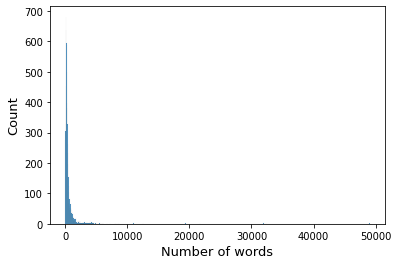

In [4]:
# get the number of words in each sample
doc_len = train.text.apply(lambda doc: len(doc.split(' '))).to_numpy()
max_words = 500

# plot histogram
histogram1 = sns.histplot(doc_len)
plt.xlabel("Number of words", fontsize=13)
plt.ylabel("Count", fontsize=13)
histogram1.figure.savefig(plots_dir / "histogram_original_data1")

print(f"Average document: {int(doc_len.mean())} words")
print(f"Longest document: {doc_len.max()} words")
print(f"Max required words: {max_words} words")

Number of training examples: 6284
Number of test examples: 1563
Proportion of training examples: 76.05%
Proportion of test examples: 76.02%


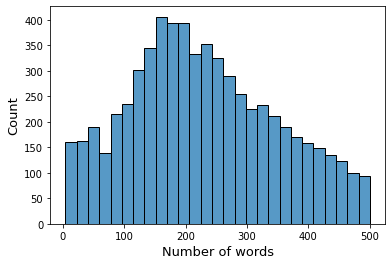

In [5]:
# removing any documents with len(words) >= 500
train500 = train[train.text.apply(lambda x: len(x.split(' '))) <= max_words]
test500 = test[test.text.apply(lambda x: len(x.split(' '))) <= max_words]

histogram2 = sns.histplot(train500.text.apply(lambda x: len(x.split(' '))))
plt.xlabel("Number of words", fontsize=13)
plt.ylabel("Count", fontsize=13)
histogram2.figure.savefig(plots_dir / "histogram_original_data2")

print(f"Number of training examples: {train500.shape[0]}")
print(f"Number of test examples: {test500.shape[0]}")

print(f"Proportion of training examples: {100*train500.shape[0] / train.shape[0]:.2f}%")
print(f"Proportion of test examples: {100*test500.shape[0] / test.shape[0]:.2f}%")

In [6]:
# get the number of words in each sample
doc_len = train500.text.apply(lambda doc: len(doc.split(' '))).to_numpy()
max_words = 500

print(f"Average document: {int(doc_len.mean())} words")
print(f"Longest document: {doc_len.max()} words")
print(f"Max required words: {max_words} words")

Average document: 229 words
Longest document: 500 words
Max required words: 500 words


In [7]:
vocab_count = Counter()
vocab_count500 = Counter()

train.text.str.split().apply(vocab_count.update)
train500.text.str.split().apply(vocab_count500.update)

vocab_count = dict(vocab_count)
vocab_count500 = dict(vocab_count500)


print(f"Number of distinct words in the original data set: {len(vocab_count)}")
print(f"Number of distinct words in the subset: {len(vocab_count500)}")

#sns.histplot(vocab_count.values())

print(f"Ratio: {100*len(vocab_count500) / len(vocab_count):.2f}")

Number of distinct words in the original data set: 290028
Number of distinct words in the subset: 135779
Ratio: 46.82


# Cleaned dataset

In [8]:
train = pd.read_csv(data_dir / 'train_cleaned.csv')#.drop('Unnamed: 0', axis=1)
test = pd.read_csv(data_dir / 'test_cleaned.csv')

print(train.shape)
train.head(5)

(8263, 3)


,Unnamed: 0,text,sentiment
0,0,досудебн расследован факт покупк енпф пакет об...,0
1,1,медик рассказа состоян пострада мужчин котор с...,0
2,2,прошел год железнодорожн оператор запрет экспл...,0
3,3,итог месяц год территор республик выпущ еди...,0
4,4,аста ноябр kazakhstan today агентств рк дел ...,0


### Summary statistics for the cleaned dataset

Average document: 438 words
Longest document: 40554 words
Max required words: 500 words


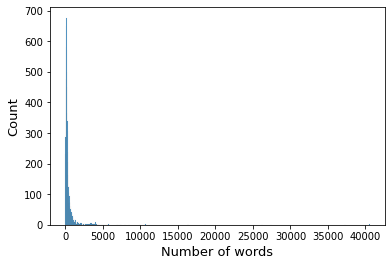

In [9]:
# get the number of words in each sample
doc_len = train.text.apply(lambda doc: len(doc.split(' '))).to_numpy()
max_words = 500

# plot histogram
histogram3 = sns.histplot(doc_len)
plt.xlabel("Number of words", fontsize=13)
plt.ylabel("Count", fontsize=13)
histogram3.figure.savefig(plots_dir / "histogram_cleaned_data1")

print(f"Average document: {int(doc_len.mean())} words")
print(f"Longest document: {doc_len.max()} words")
print(f"Max required words: {max_words} words")

Number of training examples: 6606
Number of test examples: 1663
Proportion of training examples: 79.95%
Proportion of test examples: 80.89%


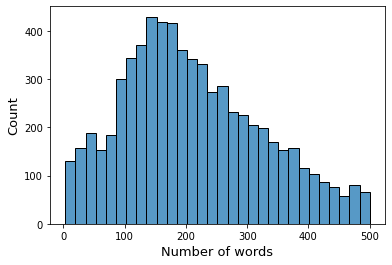

In [10]:
# removing any documents with len(words) >= 500
train500 = train[train.text.apply(lambda x: len(x.split(' '))) <= max_words]
test500 = test[test.text.apply(lambda x: len(x.split(' '))) <= max_words]

histogram4 = sns.histplot(train500.text.apply(lambda x: len(x.split(' '))))
plt.xlabel("Number of words", fontsize=13)
plt.ylabel("Count", fontsize=13)
histogram4.figure.savefig(plots_dir / "histogram_cleaned_data2")


print(f"Number of training examples: {train500.shape[0]}")
print(f"Number of test examples: {test500.shape[0]}")

print(f"Proportion of training examples: {100*train500.shape[0] / train.shape[0]:.2f}%")
print(f"Proportion of test examples: {100*test500.shape[0] / test.shape[0]:.2f}%")

In [11]:
vocab_count = Counter()
vocab_count500 = Counter()

train.text.str.split().apply(vocab_count.update)
train500.text.str.split().apply(vocab_count500.update)

vocab_count = dict(vocab_count)
vocab_count500 = dict(vocab_count500)


print(f"Number of distinct words in the original data set: {len(vocab_count)}")
print(f"Number of distinct words in the subset: {len(vocab_count500)}")

#sns.histplot(vocab_count.values())

print(f"Ratio: {100*len(vocab_count500) / len(vocab_count):.2f}")

Number of distinct words in the original data set: 69372
Number of distinct words in the subset: 37224
Ratio: 53.66


### Determining dataset-dependent variables

In [12]:
# dimension of word embedding space
embedding_size = 30
# max sequence = 500
max_seq_length = max_words

### Integer-encode training data and test data

In [13]:
X_train = train500.text
y_train = train500.sentiment

X_test = test500.text

# integer encode X_train
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
padded_train = pad_sequences(tokenized_train, maxlen=max_seq_length, padding='post')

# integer encode X_test
tokenized_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(tokenized_test, maxlen=max_seq_length, padding='post')

# one-hot encode y_train
labels = to_categorical(y_train)

In [14]:
# total vocabulary size for entire training dataset 
vocab_size = len(tokenizer.word_index) + 1

### Instantiate TrainAndSave object

In [15]:
from core.ukraine_utilities import TrainAndSave

saver = TrainAndSave(padded_train, labels, vocab_size, embedding_size, max_words)

help(saver)

Help on TrainAndSave in module core.ukraine_utilities object:

class TrainAndSave(builtins.object)
 |  TrainAndSave(X_train, y_train, vocab_size, embedding_size, max_words)
 |  
 |  class for training a model, and then exporting a JSON object and plotting
 |  
 |  Methods defined here:
 |  
 |  __init__(self, X_train, y_train, vocab_size, embedding_size, max_words)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  save(self, model, num_epochs, val, plots_dir, models_dir)
 |      train the model, generate JSON and plots, and save in respective locations
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



## Base Model CNN

Training base models using CNN units in the range of 64, 128, 256, 512, 1024, 2048

Epoch 1/10
166/166 [==============================] - 3s 18ms/step - loss: 0.9713 - accuracy: 0.5006 - val_loss: 0.8867 - val_accuracy: 0.5703
Epoch 2/10
166/166 [==============================] - 3s 17ms/step - loss: 0.7494 - accuracy: 0.6688 - val_loss: 0.7350 - val_accuracy: 0.6460
Epoch 3/10
166/166 [==============================] - 3s 18ms/step - loss: 0.5475 - accuracy: 0.7903 - val_loss: 0.6699 - val_accuracy: 0.6906
Epoch 4/10
166/166 [==============================] - 3s 18ms/step - loss: 0.3882 - accuracy: 0.8654 - val_loss: 0.6723 - val_accuracy: 0.7042
Epoch 5/10
166/166 [==============================] - 3s 18ms/step - loss: 0.2774 - accuracy: 0.9020 - val_loss: 0.6942 - val_accuracy: 0.7103
Epoch 6/10
166/166 [==============================] - 3s 18ms/step - loss: 0.2118 - accuracy: 0.9198 - val_loss: 0.7498 - val_accuracy: 0.7065
Epoch 7/10
166/166 [==============================] - 3s 18ms/step - loss: 0.1754 - accuracy: 0.9277 - val_loss: 0.7950 - val_accuracy: 0.6982

Epoch 8/10
166/166 [==============================] - 45s 273ms/step - loss: 0.1207 - accuracy: 0.9491 - val_loss: 1.0677 - val_accuracy: 0.6936
Epoch 9/10
166/166 [==============================] - 46s 276ms/step - loss: 0.1227 - accuracy: 0.9464 - val_loss: 1.0932 - val_accuracy: 0.6974
Epoch 10/10
166/166 [==============================] - 46s 279ms/step - loss: 0.1106 - accuracy: 0.9451 - val_loss: 1.1187 - val_accuracy: 0.6974


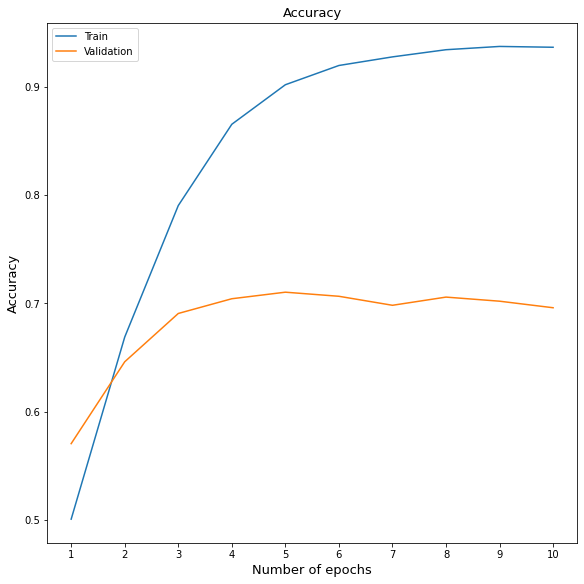

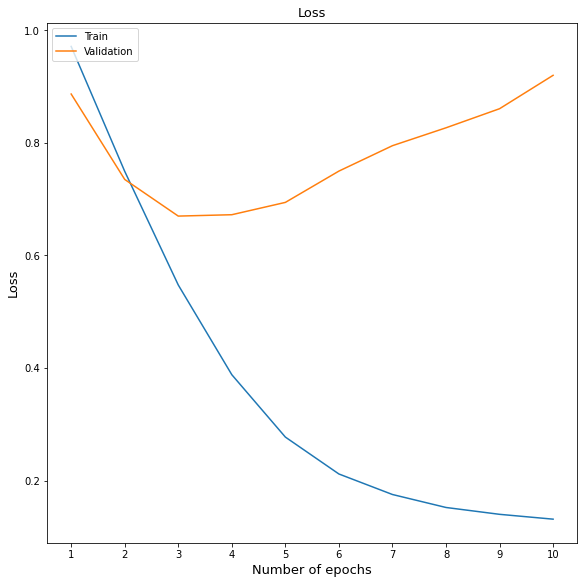

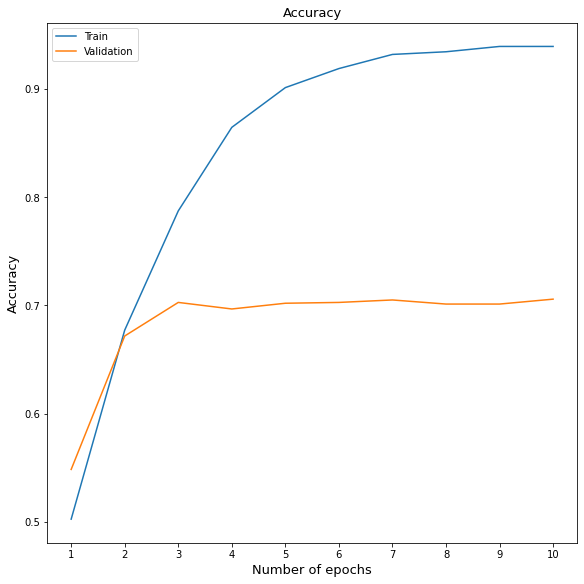

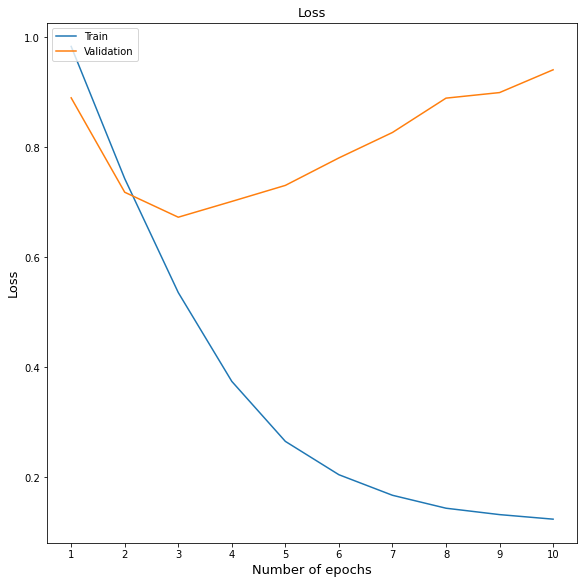

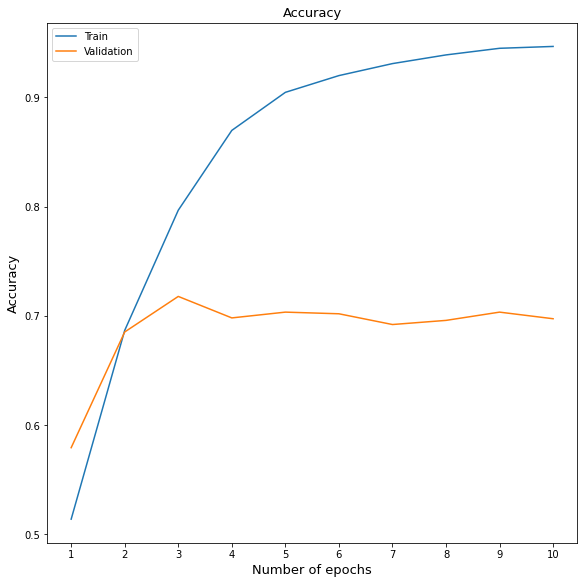

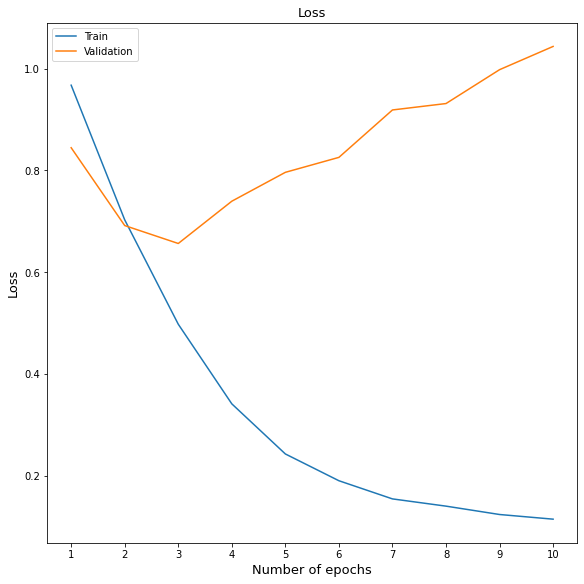

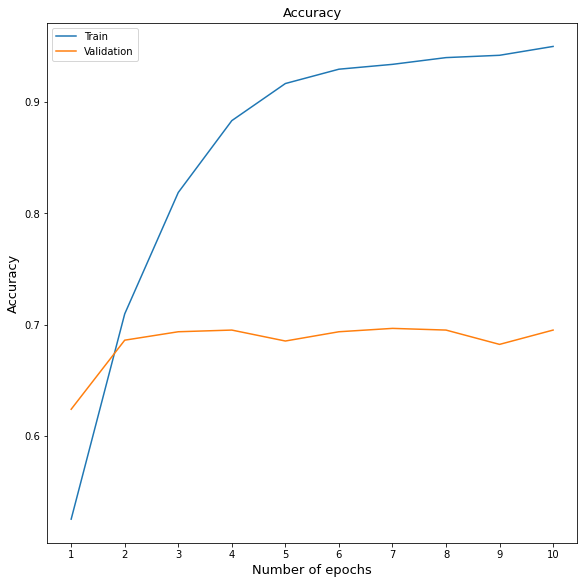

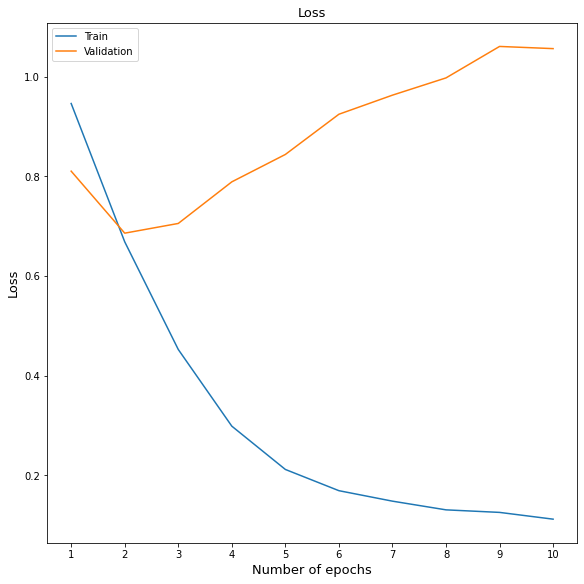

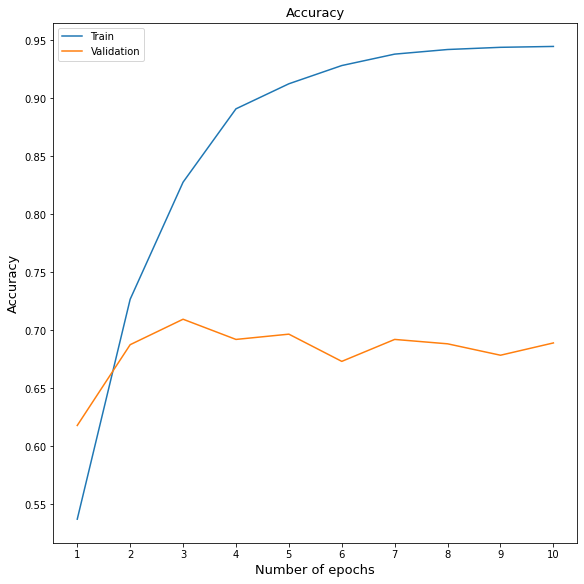

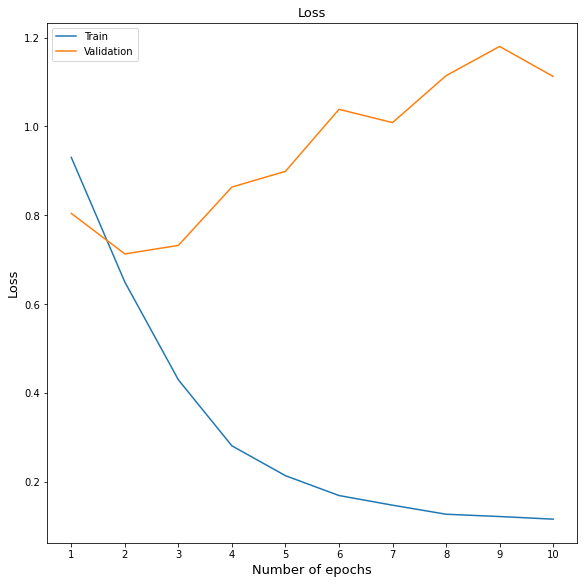

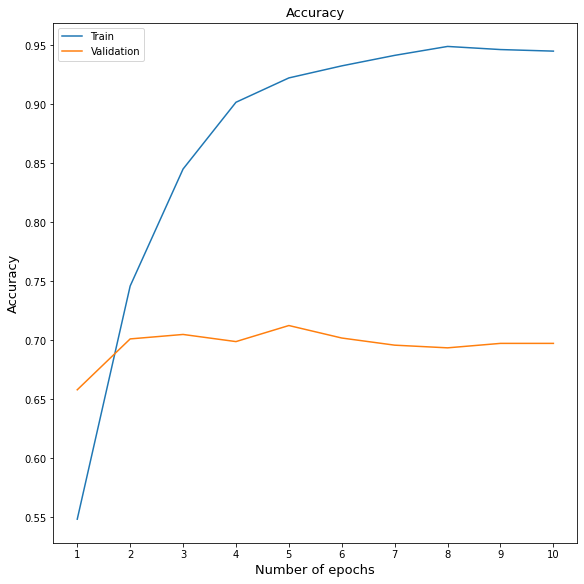

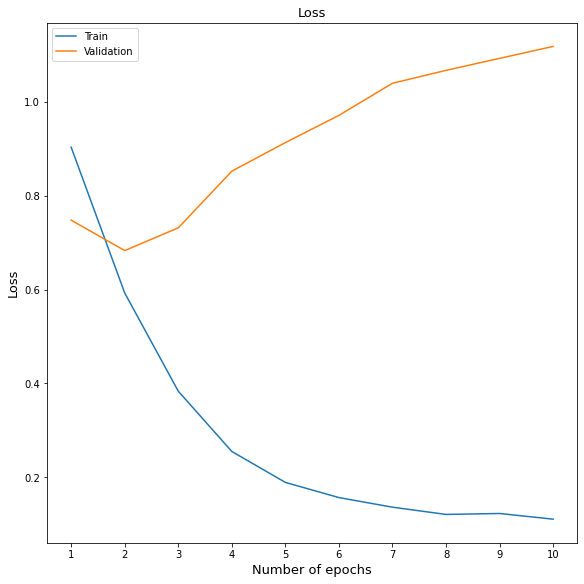

In [17]:
cnn_units = [64*2**i for i in range(0,6)]

for i in cnn_units:
    
    name = 'base_cnn' + f'_{i}'
    
    model = Sequential(name=name)
    model.add(layers.Embedding(vocab_size, embedding_size, input_length=max_seq_length))
    model.add(layers.Conv1D(i, 3, padding='valid', activation='relu', strides=1))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    
    saver.save(model, 10, 0.2, plots_dir, models_dir)

# Deep CNNs

Deeper CNN architecture with Conv1D(units) and Dense(units / 2) for units = [64, 128, 256, 512, 1024, 2048]

Epoch 1/10
166/166 [==============================] - 4s 19ms/step - loss: 1.5618 - accuracy: 0.3986 - val_loss: 1.0338 - val_accuracy: 0.4554
Epoch 2/10
166/166 [==============================] - 3s 18ms/step - loss: 1.1524 - accuracy: 0.4763 - val_loss: 1.0146 - val_accuracy: 0.4554
Epoch 3/10
166/166 [==============================] - 3s 18ms/step - loss: 0.9630 - accuracy: 0.5590 - val_loss: 0.9435 - val_accuracy: 0.4871
Epoch 4/10
166/166 [==============================] - 3s 18ms/step - loss: 0.8680 - accuracy: 0.6041 - val_loss: 0.8559 - val_accuracy: 0.5726
Epoch 5/10
166/166 [==============================] - 3s 19ms/step - loss: 0.7944 - accuracy: 0.6501 - val_loss: 0.7977 - val_accuracy: 0.6172
Epoch 6/10
166/166 [==============================] - 3s 19ms/step - loss: 0.7092 - accuracy: 0.6991 - val_loss: 0.7700 - val_accuracy: 0.6362
Epoch 7/10
166/166 [==============================] - 3s 19ms/step - loss: 0.6604 - accuracy: 0.7267 - val_loss: 0.7739 - val_accuracy: 0.6346

Epoch 8/10
166/166 [==============================] - 48s 287ms/step - loss: 0.2687 - accuracy: 0.9109 - val_loss: 0.9353 - val_accuracy: 0.7065
Epoch 9/10
166/166 [==============================] - 47s 285ms/step - loss: 0.2374 - accuracy: 0.9224 - val_loss: 1.0280 - val_accuracy: 0.6921
Epoch 10/10
166/166 [==============================] - 49s 296ms/step - loss: 0.2279 - accuracy: 0.9211 - val_loss: 0.9638 - val_accuracy: 0.7110


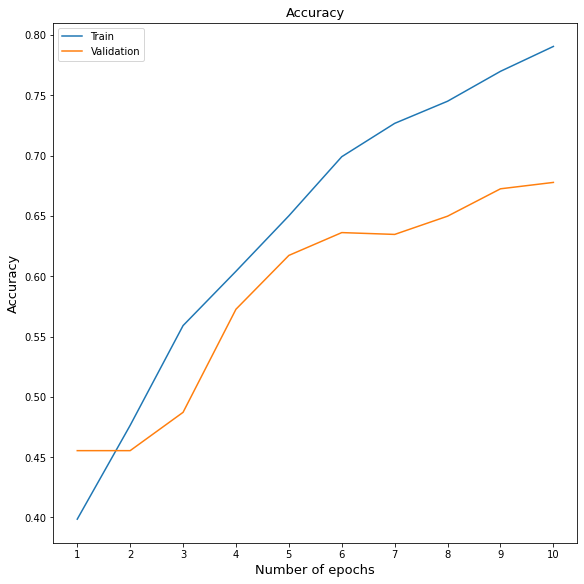

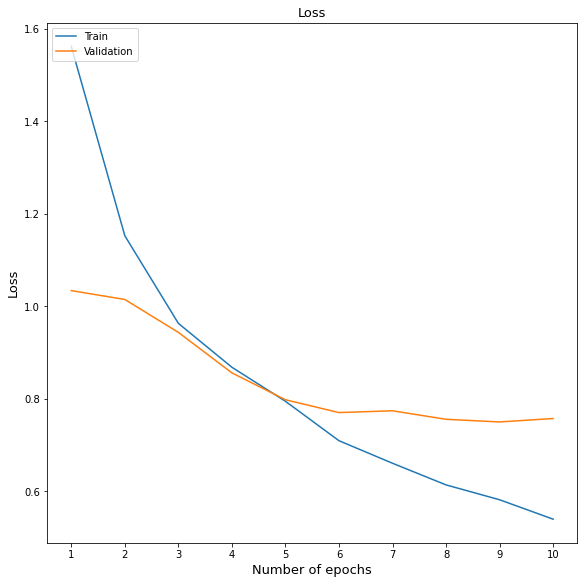

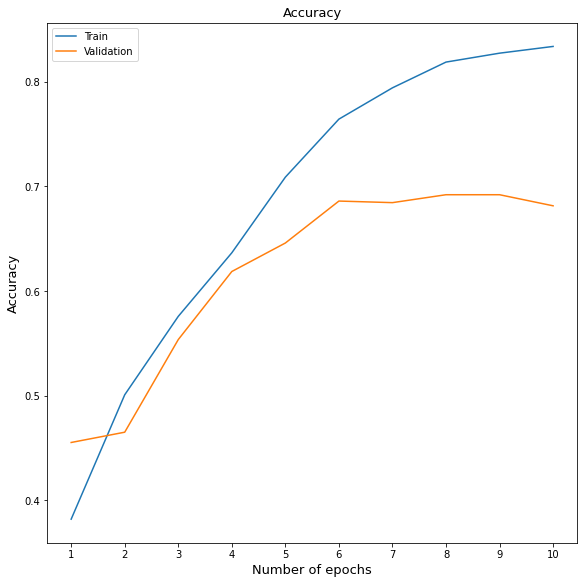

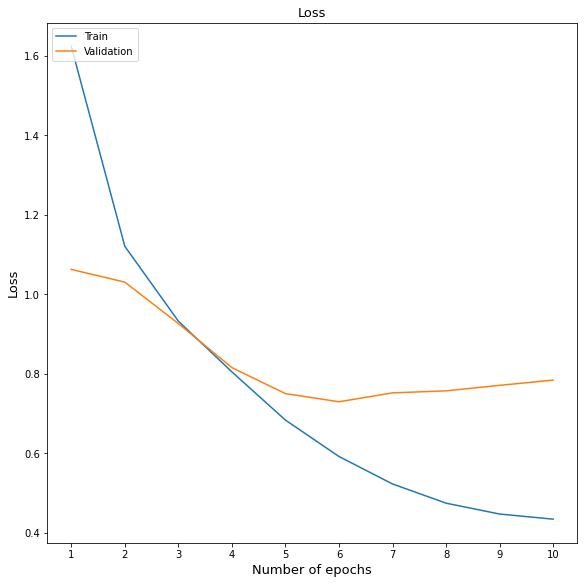

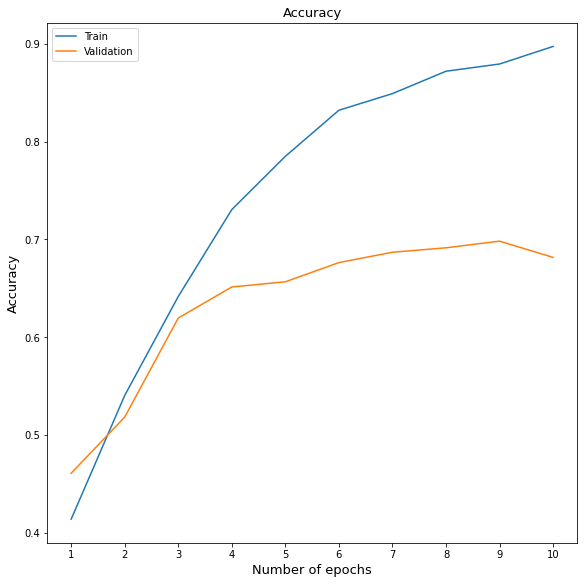

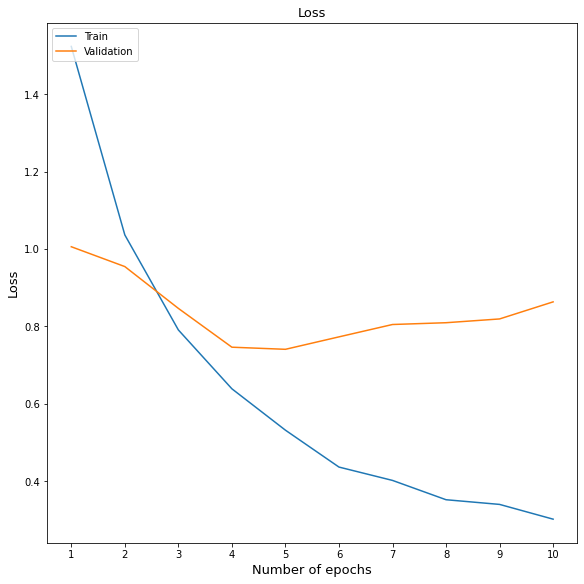

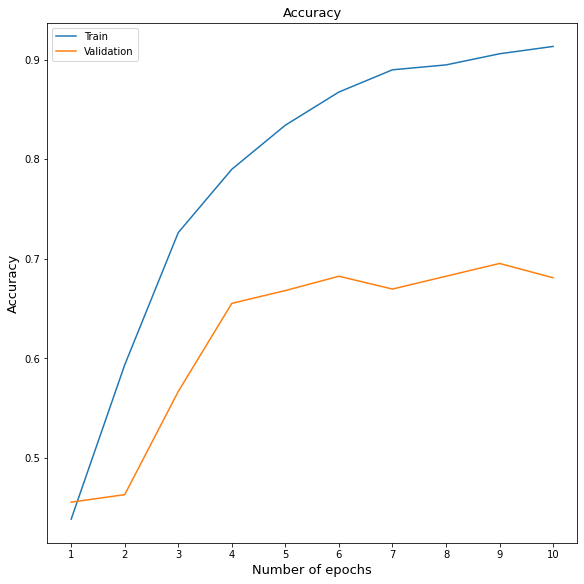

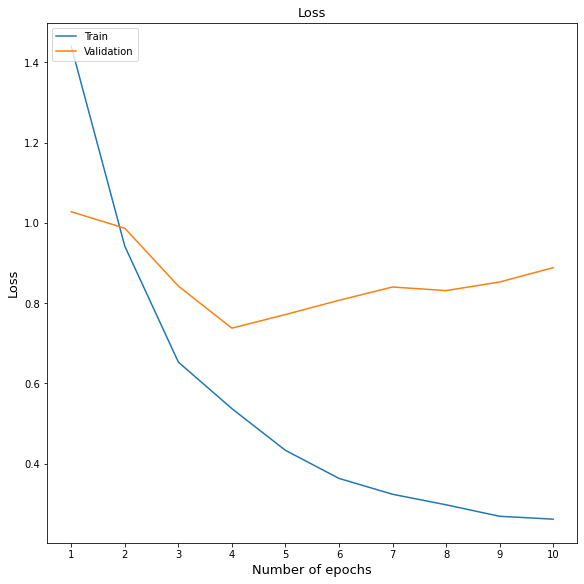

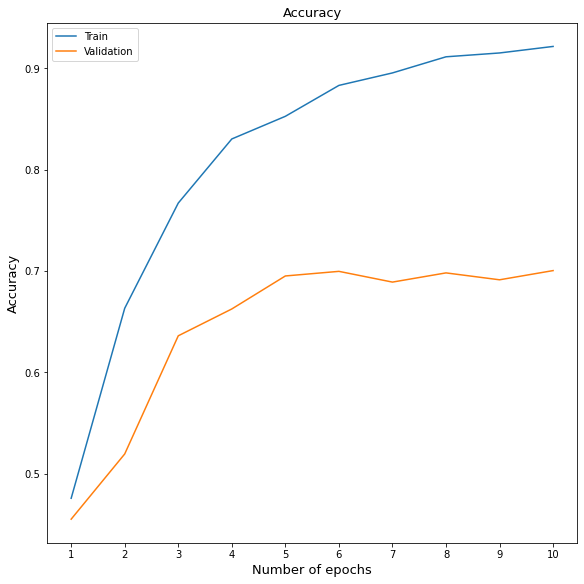

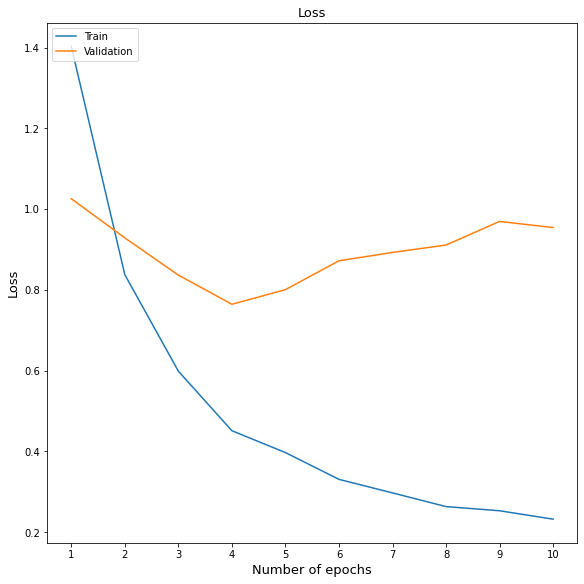

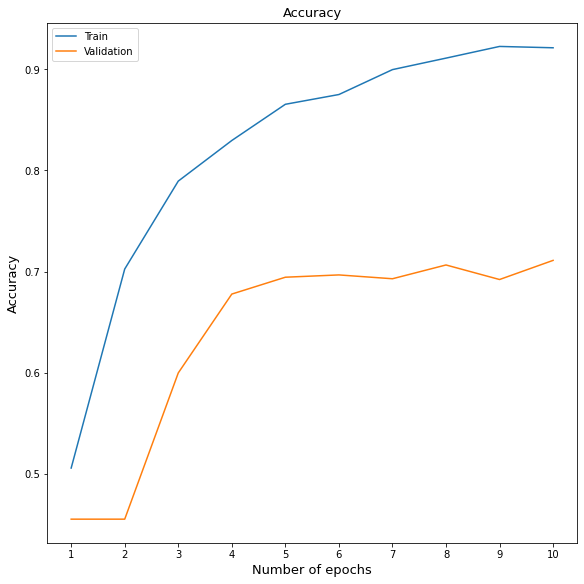

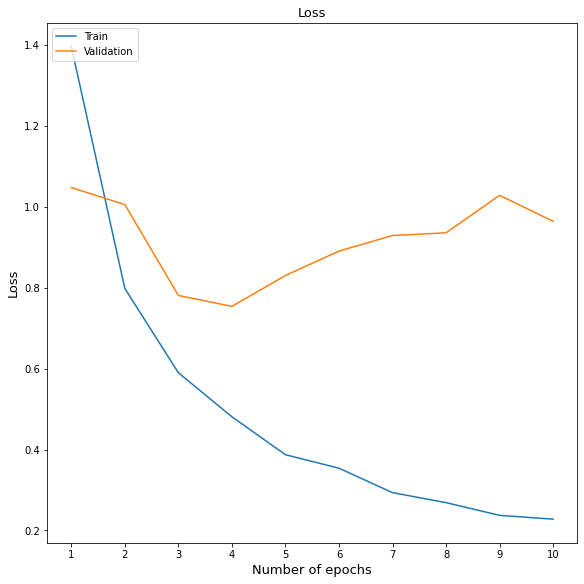

In [21]:
cnn_units = [64*2**i for i in range(0,6)]

for i in cnn_units:
    name = name = 'two_layer_cnn' + f'_{int(i)}'
    model = Sequential(name=name)
    model.add(layers.Embedding(vocab_size, embedding_size, input_length=max_seq_length))
    model.add(layers.Conv1D(i, 3, padding='valid', activation='relu', strides=1))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(i / 2, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    saver.save(model, 10, 0.2, plots_dir, models_dir)

Even deeper CNN with many Dense layers (Conv1D kept at 512 filters)

In [67]:
cnn_units = [64*2**i for i in range(0,6)]

for i in range(0, 5):
    name = 'three_layer_cnn' + f'_{int(i)}'
    print(name)

    model = Sequential(name=name)
    model.add(layers.Embedding(vocab_size, embedding_size, input_length=max_seq_length))
    model.add(layers.Conv1D(512, 3, padding='same', activation='relu', strides=1))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(i, activation='relu'))    
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(i / 2, activation='relu'))    
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    saver.save(model, 10, 0.2, plots_dir, models_dir)

three_layer_cnn_0
Epoch 1/10
133/133 [==============================] - 10s 66ms/step - loss: 1.0986 - accuracy: 0.1642 - val_loss: 1.0986 - val_accuracy: 0.1523
Epoch 2/10
133/133 [==============================] - 9s 65ms/step - loss: 1.0986 - accuracy: 0.1642 - val_loss: 1.0986 - val_accuracy: 0.1523
Epoch 3/10
110/133 [=======================>......] - ETA: 1s - loss: 1.0986 - accuracy: 0.1668

KeyboardInterrupt: 

# Training with pretrained embeddings

Embedding layer: news_upos_skipgram_300_5_2019

Dimension of pretrained embeddings: 300

In [ ]:
embedding_size = 300
cnn_units = [64*2**i for i in range(0,6)]

path_to_model_file = "rusvectores/model.txt"

embeddings_index = {}
with open(path_to_model_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word.split('_')[0]] = coefs

print("Found %s word vectors." % len(embeddings_index))

#create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape


for i in cnn_units:
    name= 'rusvectores_embedding' + f'_{int(i)}'

    model = Sequential(name=name)
    model.add(layers.Embedding(vocab_size, embedding_size,
                               weights=[embedding_matrix],
                               input_length=max_seq_length,
                               trainable=False))
    model.add(layers.Conv1D(i, 3, padding='valid', activation='relu', strides=1))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    saver.save(model, 10, 0.2, plots_dir, models_dir)

### Training the same model with embedding layer to compare

In [ ]:
embedding_size=300
cnn_units = [64*2**i for i in range(0,6)]


for i in cnn_units:
    name= 'embeddings_base' + f'_{int(i)}'

    model = Sequential(name=name)
    model.add(layers.Embedding(vocab_size, embedding_size,
                               input_length=max_seq_length))
    model.add(layers.Conv1D(i, 3, padding='valid', activation='relu', strides=1))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    saver.save(model, 10, 0.2, plots_dir, models_dir)

# Hyperparameter optimisation

Define the hypermodel for testing

* Conv1D filters range(64, 4096) with log sampling
* Conv1D activation function ['relu', 'tanh']
* Conv1D kernel size range(3, 100) with log sampling
* Learning rate range(1e-4, 1e-2) with log sampling

In [35]:
def build_model(hp, name='test'):
    model = Sequential(name=name)
    model.add(layers.Embedding(vocab_size, embedding_size,
                               input_length=max_seq_length))
    model.add(layers.Conv1D(filters=hp.Int('filters', min_value=64, max_value=1024, sampling="log"),
                            activation=hp.Choice('activation', ['relu', 'tanh']),
                            kernel_size=hp.Int('kernel_size', min_value=3, max_value=100, sampling="log"),
                            padding='valid',
                            strides=1))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(3, activation='softmax'))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='ideal_model',
    project_name='ukraine_model'
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 1, 'sampling': 'log'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 100, 'step': 1, 'sampling': 'log'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


### Do the hyperparameter search using Bayesian optimisation:

In [36]:
tuner.search(padded_train, labels, epochs=10, validation_split=0.2)
best_model = tuner.get_best_models()[0]

print(tuner.results_summary())

Trial 20 Complete [00h 03m 05s]
val_accuracy: 0.7329803109169006

Best val_accuracy So Far: 0.7329803109169006
Total elapsed time: 01h 56m 09s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ideal_model/ukraine_model
Showing 10 best trials
Trial summary
Hyperparameters:
filters: 188
activation: relu
kernel_size: 52
lr: 0.0002383305489562791
Score: 0.7329803109169006
Trial summary
Hyperparameters:
filters: 194
activation: relu
kernel_size: 35
lr: 0.0008212391660289132
Score: 0.7329803109169006
Trial summary
Hyperparameters:
filters: 145
activation: relu
kernel_size: 53
lr: 0.0005053821016944706
Score: 0.7299546003341675
Trial summary
Hyperparameters:
filters: 174
activation: tanh
kernel_size: 56
lr: 0.00036965955746739456
Score: 0.7299546003341675
Trial summary
Hyperparameters:
filters: 138
activation: tanh
kernel_size: 100
lr: 0.0005134184504169606
Score: 0.7239031791687012
Trial summary
Hyperparameters:
filters: 189
activation: relu
kernel_size: 51
lr: 0.0002353693764

### Retrain on the full training data based on the optimal hyperparameters

In [37]:
best_hps = tuner.get_best_hyperparameters(5)

best_filters = best_hps[0].get('filters')
best_activation = best_hps[0].get('activation')
best_kernel_size = best_hps[0].get('kernel_size')
best_learning_rate = best_hps[0].get('lr')

print(f"Best filters: {best_filters}")
print(f"Best activation: {best_activation}")
print(f"Best kernel size: {best_kernel_size}")
print(f"Best learning rate: {best_learning_rate}")

Best filters: 188
Best activation: relu
Best kernel size: 52
Best learning rate: 0.0002383305489562791


In [44]:
X_train, X_test, y_train, y_test = train_test_split(padded_train, labels, test_size=0.2)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

saver = TrainAndSave(X_train, y_train, vocab_size, embedding_size, max_words)

X_train shape: (5284, 500)
y_train shape: (5284, 3)
X_test shape: (1322, 500)
y_test shape: (1322, 3)


Epoch 1/20
133/133 [==============================] - 19s 140ms/step - loss: 1.0209 - accuracy: 0.4729 - val_loss: 0.9928 - val_accuracy: 0.4872
Epoch 2/20
133/133 [==============================] - 18s 133ms/step - loss: 0.9197 - accuracy: 0.5765 - val_loss: 0.8595 - val_accuracy: 0.6149
Epoch 3/20
133/133 [==============================] - 17s 127ms/step - loss: 0.7188 - accuracy: 0.6925 - val_loss: 0.7404 - val_accuracy: 0.6802
Epoch 4/20
133/133 [==============================] - 17s 126ms/step - loss: 0.5401 - accuracy: 0.7857 - val_loss: 0.7023 - val_accuracy: 0.6906
Epoch 5/20
133/133 [==============================] - 17s 127ms/step - loss: 0.4082 - accuracy: 0.8446 - val_loss: 0.6975 - val_accuracy: 0.6944
Epoch 6/20
133/133 [==============================] - 17s 131ms/step - loss: 0.3098 - accuracy: 0.8857 - val_loss: 0.7148 - val_accuracy: 0.7039
Epoch 7/20
133/133 [==============================] - 18s 136ms/step - loss: 0.2428 - accuracy: 0.9106 - val_loss: 0.7437 - val_ac

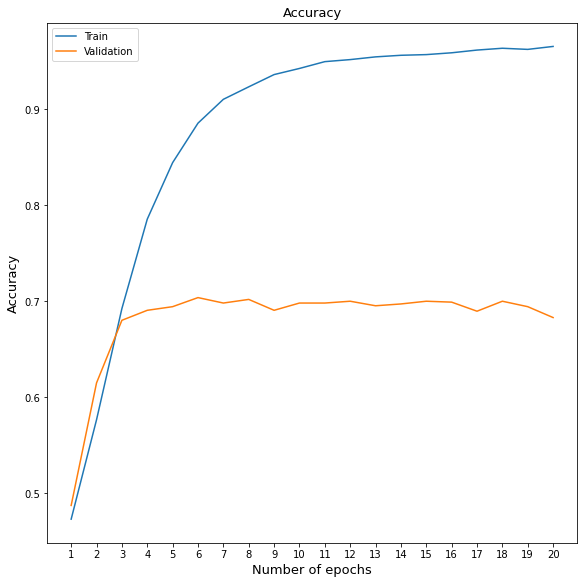

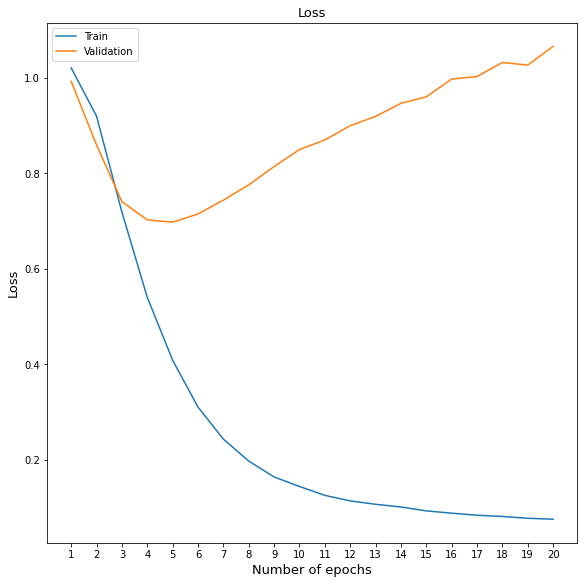

In [45]:
model = build_model(best_hps[0], 'best_model')

saver.save(model, 20, 0.2, plots_dir, models_dir)

Epoch 1/6
133/133 [==============================] - 18s 135ms/step - loss: 1.0195 - accuracy: 0.4755 - val_loss: 0.9874 - val_accuracy: 0.4816
Epoch 2/6
133/133 [==============================] - 19s 140ms/step - loss: 0.9137 - accuracy: 0.5706 - val_loss: 0.8480 - val_accuracy: 0.6149
Epoch 3/6
133/133 [==============================] - 19s 139ms/step - loss: 0.7096 - accuracy: 0.7017 - val_loss: 0.7353 - val_accuracy: 0.6641
Epoch 4/6
133/133 [==============================] - 20s 147ms/step - loss: 0.5368 - accuracy: 0.7911 - val_loss: 0.6901 - val_accuracy: 0.6887
Epoch 5/6
133/133 [==============================] - 20s 152ms/step - loss: 0.4063 - accuracy: 0.8512 - val_loss: 0.6871 - val_accuracy: 0.6973
Epoch 6/6
133/133 [==============================] - 20s 147ms/step - loss: 0.3117 - accuracy: 0.8902 - val_loss: 0.7031 - val_accuracy: 0.6973


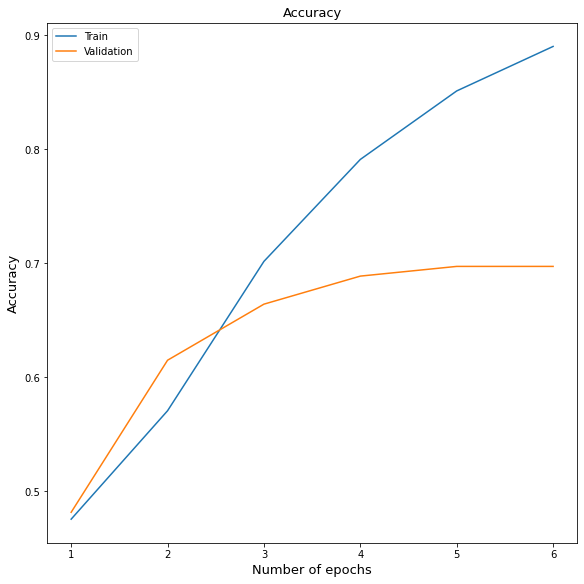

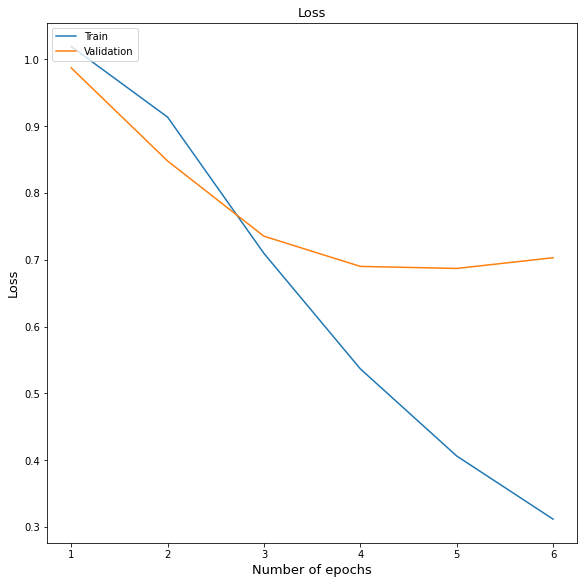

In [46]:
model = build_model(best_hps[0], 'best_model_best_val_acc')

saver.save(model, 6, 0.2, plots_dir, models_dir)

In [47]:
model.save(models_dir / 'best_model_best_val_acc')

INFO:tensorflow:Assets written to: models/best_model_best_val_acc/assets


In [57]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [61]:
results = metrics.classification_report(y_test, y_pred, digits=3)

print(results)

              precision    recall  f1-score   support

           0      0.751     0.589     0.661       246
           1      0.681     0.726     0.703       592
           2      0.713     0.733     0.723       484

    accuracy                          0.703      1322
   macro avg      0.715     0.683     0.696      1322
weighted avg      0.706     0.703     0.703      1322

